In [1]:
# from tools import customer_details

C:\Users\supri\OneDrive\Desktop\LLM project\retail_chatbot\tools.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  transaction_json = pd.read_csv("data/transactions.csv").set_index('customer_id').T.to_dict()


In [14]:
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_mistralai import ChatMistralAI

In [15]:
# convert_to_openai_tool(customer_details)

In [16]:
# {
#         "type": "function",
#         "function": {
#             "name": "retrieve_payment_status",
#             "description": "Get payment status of a transaction",
#             "parameters": {
#                 "type": "object",
#                 "properties": {
#                     "transaction_id": {
#                         "type": "string",
#                         "description": "The transaction id.",
#                     }
#                 },
#                 "required": ["transaction_id"],
#             },
#         },
#     }

In [17]:
from phoenix.otel import register
tracer_provider = register(
  project_name="Askit",  # Default is 'default'
  auto_instrument=True  # Auto-instrument your app based on installed dependencies
)

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


OpenTelemetry Tracing Details
|  Phoenix Project: Askit
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [18]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from system_prompts import ROUTER_SYSTEM_PROMPT, ANSWER_GENERATOR_PROMPT
from tools import customer_details, all_transaction_details, general_inquiry, policy_documents, get_most_recent_transaction
import random
import json
import os 

secrets = json.load(open("secrets.json"))
os.environ["MISTRAL_API_KEY"] = secrets["mistral_api_key"]

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    customer_id: str
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatMistralAI(
    model="mistral-large-latest",
    temperature=0,
    max_retries=2,
    max_tokens=150,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
)

router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ROUTER_SYSTEM_PROMPT),
        ("placeholder", "{msgs}"),
    ]
)

answer_generator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ANSWER_GENERATOR_PROMPT),
        ("user", "{text}"),
    ]
)

router_llm = router_prompt | llm
answer_generator = answer_generator_prompt | llm

def router(state: State):
    return {"messages": [router_llm.invoke({ "msgs":state["messages"]})]}

def generate_answer(state: State):
    call_tool = state['messages'][-1].content
    response = ''
    if call_tool == 'customer_details':
        response = customer_details(state['customer_id'])
    if call_tool == 'all_transaction_details':
        response = all_transaction_details(state['customer_id'])
    if call_tool == 'general_inquiry':
        response = general_inquiry(state['customer_id'])
    if call_tool == 'policy_documents':
        response = policy_documents(state['customer_id'])
    if call_tool == 'get_most_recent_transaction':
        response = get_most_recent_transaction(state['customer_id'])
    return {"messages": [answer_generator.invoke({"text":state["messages"][-2].content, "additional_information":response})]}
    
graph_builder.add_node("router", router)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "router")
graph_builder.add_edge("router", "generate_answer")
graph_builder.add_edge("generate_answer", END)
graph = graph_builder.compile()



In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}],"customer_id":"CUST0{:02d}".format(random.randint(1, 20))}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
    return value["messages"][-1].content

In [22]:
def graph_output(user_query, customer_id):
    events = graph.stream({"messages": [{"role": "user", "content": user_query}],"customer_id":customer_id})
    list_events = [x for x in events]
    output = list_events[-1]['generate_answer']['messages'][-1].content
    return output

In [25]:
list_events = [x for x in events]

Transient error StatusCode.UNAVAILABLE encountered while exporting traces to localhost:4317, retrying in 1s.


In [39]:
list_events[-1]['generate_answer']['messages'][-1].content

"Your most recent transaction was on '2025-03-01' with the transaction ID 'TXN000125'. The total cost of this transaction was $13265.34."

In [ ]:
def get_output(

In [20]:
stream_graph_updates("what is my most recent transaction")

Transient error StatusCode.UNAVAILABLE encountered while exporting traces to localhost:4317, retrying in 1s.


Assistant: get_most_recent_transaction
Assistant: Your most recent transaction (TXN000037) was on 2025-02-24. Here are the details:

- **Smartphones Product 84021**: Quantity: 2, Total cost: $273.88
- **Smartphones Product 41170**: Quantity: 4, Total cost: $3920.00
- **Smartphones Product 80033**: Quantity: 1, Total cost: $474.91
- **Furniture Product 81500**: Quantity: 5, Total cost: $7


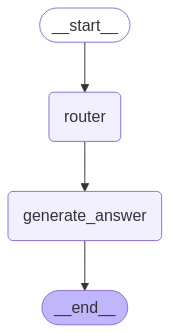

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass